# Data pipeline example

Example of standard data pipeline for training neural networks, including feature extraction and writing 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import random
import numpy as np
import librosa

In [3]:
import tensorflow as tf
from tensorflow.python.framework import dtypes

In [4]:
tf.__version__

'2.0.0'

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
from phaunos_ml.utils.dataset_utils import read_dataset_file, dataset2tfrecords
from phaunos_ml.utils.tf_serialization_utils import serialized2example, serialized2data
from phaunos_ml.utils.dataug_utils import Mixup, time_mask, time_warp, frequency_mask
from phaunos_ml.utils.tf_feature_utils import MelSpectrogram

In [7]:
ROOT_PATH = './data/birdid_dataset/'
BIRDS_DIR = 'birds'
NOISE_DIR = 'noise'
DATASET_BIRDS_FILE = os.path.join(ROOT_PATH, BIRDS_DIR, 'dataset.csv')
LABEL_FILE = os.path.join(ROOT_PATH, BIRDS_DIR, 'labels.csv')
DATASET_NOISE_FILE = os.path.join(ROOT_PATH, NOISE_DIR, 'dataset.csv')
AUDIO_DIR = 'audio'
ANNOTATION_DIR = 'annotations'
FEATURE_DIR = 'features'
ACTIVITY_DETECTION_CFG = os.path.join(ROOT_PATH, 'activity_detection.json')

In [8]:
SR = 22050

In [9]:
CLASS_LIST = [268, 324]

In [10]:
BATCH_SIZE = 4

## Configure activity detector

Because bird vocalisations are very sparse (e.g. only a few seconds of vocalisations in a 1 min audio file), and we do not want our model to be trained with audio chunks containing no activity, we must detect audio chunks containing activity.

Audio chunks containing audio activity will be written to a directory named <b><i>positive</i></b> and audio chunks containing no activity will be written to <b><i>negative</i></b>

In [11]:
from nsb_aad.frame_based_detectors.mario_detector import MarioDetector

In [12]:
activity_detection_cfg = json.load(open(ACTIVITY_DETECTION_CFG, 'r'))
activity_detector = MarioDetector(activity_detection_cfg)
activity_detection_cfg

{'sample_rate': 22050,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 200,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

## Configure feature extractor

We want to use mel-spectrogram as our model input, but because some audio augmentation methods (e.g. Mixup) are applied to the raw audio, we write raw audio chunks of 1s, with no overlap, to the TFRecords, and we will a compute the mel-spectrogram at run time

In [13]:
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor

In [14]:
segment_duration = 1 # in seconds
segment_hop_duration = 1 # in seconds
feature_extractor = AudioSegmentExtractor(
    sr=SR,
    example_duration=segment_duration,
    example_hop_duration=segment_hop_duration)

## Write data to TFRecords

### Write bird TFRecords

In [15]:
# audio + annotation files -> TFRecords
dataset2tfrecords(
        os.path.join(ROOT_PATH, BIRDS_DIR),
        DATASET_BIRDS_FILE,
        os.path.join(ROOT_PATH, BIRDS_DIR, FEATURE_DIR),
        feature_extractor,
        activity_detector=activity_detector,
        min_activity_dur=0.05,
        audio_dirname=AUDIO_DIR,
        annotation_dirname=ANNOTATION_DIR,
        with_labels=True
)

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


In [16]:
tfrecord_birds_path = os.path.join(ROOT_PATH, BIRDS_DIR, FEATURE_DIR, 'positive', AUDIO_DIR)

In [17]:
# inspect a random TFRecord
# containing the features and labels (shown as one-hot encoded labels)
tfrecord_filename = os.path.join(
    tfrecord_birds_path,
    random.sample(os.listdir(tfrecord_birds_path), 1)[0]
)
dataset = tf.data.TFRecordDataset([tfrecord_filename])
dataset = dataset.map(lambda data: serialized2data(data, CLASS_LIST))
data = [d for d in dataset]
print(data)

[(<tf.Tensor: id=155, shape=(1, 22050), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ..., -0.00253296,
        -0.00177002, -0.00024414]], dtype=float32)>, <tf.Tensor: id=156, shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>, <tf.Tensor: id=157, shape=(), dtype=string, numpy=b'audio/XC370891.M.tf'>, <tf.Tensor: id=158, shape=(2,), dtype=float32, numpy=array([0.        , 0.99995464], dtype=float32)>), (<tf.Tensor: id=159, shape=(1, 22050), dtype=float32, numpy=
array([[ 0.00183105,  0.0027771 ,  0.00198364, ..., -0.00286865,
         0.00073242,  0.0039978 ]], dtype=float32)>, <tf.Tensor: id=160, shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>, <tf.Tensor: id=161, shape=(), dtype=string, numpy=b'audio/XC370891.M.tf'>, <tf.Tensor: id=162, shape=(2,), dtype=float32, numpy=array([1.       , 1.9999547], dtype=float32)>), (<tf.Tensor: id=163, shape=(1, 22050), dtype=float32, numpy=
array([[ 0.00564575,  0.00485229,  0.00238037, ...,  0

### Write noise TFRecords

In [18]:
# audio + annotation files -> TFRecords
dataset2tfrecords(
        os.path.join(ROOT_PATH, NOISE_DIR),
        DATASET_NOISE_FILE,
        os.path.join(ROOT_PATH, NOISE_DIR, FEATURE_DIR),
        feature_extractor,
        audio_dirname=AUDIO_DIR,
        annotation_dirname=ANNOTATION_DIR,
        with_labels=False
)

100%|██████████| 1/1 [00:00<00:00, 667.03it/s]


In [19]:
tfrecord_noise_path = os.path.join(ROOT_PATH, NOISE_DIR, FEATURE_DIR, 'positive', AUDIO_DIR)

In [20]:
# inspect a random TFRecord
# containing the features only (one-hot labels are all set to 0)
tfrecord_filename = os.path.join(
    tfrecord_noise_path,
    random.sample(os.listdir(tfrecord_noise_path), 1)[0]
)
dataset = tf.data.TFRecordDataset([tfrecord_filename])
dataset = dataset.map(lambda data: serialized2data(data, CLASS_LIST))
data = [d for d in dataset]
print(data)

[(<tf.Tensor: id=1277, shape=(1, 22050), dtype=float32, numpy=
array([[ 0.        ,  0.72683716,  0.6072998 , ...,  0.21939087,
        -0.6072998 , -0.7267761 ]], dtype=float32)>, <tf.Tensor: id=1278, shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, <tf.Tensor: id=1279, shape=(), dtype=string, numpy=b'audio/4000hz.tf'>, <tf.Tensor: id=1280, shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>)]


## Make data to feed the model

**tf.data.Dataset** is used to get the data from TFRecords.



### Get bird data

Build a dataset providing batches of deserialized, shuffled bird data.

In [21]:
# get list of files as a tensor
files_bird = [os.path.join(tfrecord_birds_path, f) for f in os.listdir(tfrecord_birds_path)]
files_bird = tf.convert_to_tensor(files_bird, dtype=dtypes.string)

# convert to tf.data.Dataset
files_bird = tf.data.Dataset.from_tensor_slices(files_bird)

# interleave the files 
dataset_bird = files_bird.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=2)

# deserialize to feature (with shape (1,1,22050)) and
# one-hot encoded labels (with shape (2,), i.e. the shape of CLASS_LIST)
dataset_bird = dataset_bird.map(lambda data: serialized2data(data, CLASS_LIST))

# shuffle
dataset_bird = dataset_bird.shuffle(100)

# batch
dataset_bird = dataset_bird.batch(BATCH_SIZE)

In [22]:
print(dataset_bird)

<BatchDataset shapes: ((None, None, None), (None, 2), (None,), (None, 2)), types: (tf.float32, tf.float32, tf.string, tf.float32)>


### Get noise data

Build a dataset providing batches of deserialized noise data, to be used in the mixup data augmentation.

In [23]:
# Get list of files as a tensor
files_noise = [os.path.join(tfrecord_noise_path, f) for f in os.listdir(tfrecord_noise_path)]

# Convert to tf.data.Dataset
files_noise = tf.data.TFRecordDataset(files_noise)

# Deserialize to feature (with shape (1,1,22050)) and
# one-hot encoded labels (with shape (2,), i.e. the shape of CLASS_LIST)
dataset_noise = files_noise.map(lambda data: serialized2data(data, CLASS_LIST))

# Repeat
dataset_noise = dataset_noise.repeat()

# Make batches
dataset_noise = dataset_noise.batch(BATCH_SIZE)

In [24]:
print(dataset_noise)

<BatchDataset shapes: ((None, None, None), (None, 2), (None,), (None, 2)), types: (tf.float32, tf.float32, tf.string, tf.float32)>


### Time-domain data augmentation

In [25]:
# Add noise to the bird data.
mixup = Mixup(max_weight=0.4)
dataset = tf.data.Dataset.zip((dataset_bird, dataset_noise))
dataset = dataset.map(lambda dataset1, dataset2: mixup.process(
    tf.expand_dims(dataset1[0],1), dataset1[1], tf.expand_dims(dataset2[0],1), dataset2[1], BATCH_SIZE))

### Compute log mel spectrogram

In [26]:
N_FFT = 512
HOP_LENGTH = 128
FMIN = 50
FMAX = 8000
N_MELS = 64

melspec_ex = MelSpectrogram(SR, N_FFT, HOP_LENGTH, N_MELS, fmin=FMIN, fmax=FMAX, log=False)
dataset = dataset.map(lambda data, labels: (
    tf.expand_dims(tf.py_function(melspec_ex.process, [tf.squeeze(data)], tf.float32), 1),
    labels)
)

In [27]:
dataset

<MapDataset shapes: (<unknown>, (None, 2)), types: (tf.float32, tf.int8)>

### Spectral-domain data augmentation

In [28]:
# Convert from channels_first (NCHW) to channels_last (NHWC) format
# to match SpecAugment requirement
dataset = dataset.map(lambda data, labels: (tf.transpose(data, [0,2,3,1]), labels))

# Time warp
dataset = dataset.map(lambda data, labels: (tf.py_function(time_warp, [data, 5], tf.float32), labels))

# Time masking
dataset = dataset.map(lambda data, labels: (tf.py_function(time_mask, [data, 10], tf.float32), labels))

# Frequency masking
dataset = dataset.map(lambda data, labels: (tf.py_function(frequency_mask, [data, 5], tf.float32), labels))

# Back to channels_first (NCHW)
dataset = dataset.map(lambda data, labels: (tf.transpose(data, [0,3,1,2]), labels))

Now dataset can be fed to **tf.keras.Model.fit**.

Let's see what data the dataset provides:

In [29]:
data = [d[0] for d in dataset]
data

[<tf.Tensor: id=2728, shape=(4, 1, 64, 169), dtype=float32, numpy=
 array([[[[1.82142735e-01, 2.06200421e-01, 1.03384681e-01, ...,
           5.86477742e-02, 9.02869180e-02, 8.45693126e-02],
          [9.02440995e-02, 8.90336633e-02, 6.02006093e-02, ...,
           4.37591188e-02, 5.55216447e-02, 3.45003493e-02],
          [5.92783652e-02, 4.13638204e-02, 5.12494519e-02, ...,
           4.79124710e-02, 5.05365059e-02, 1.30134486e-02],
          ...,
          [1.28261113e+00, 1.04606867e+00, 9.86155987e-01, ...,
           2.89765865e-01, 2.92543203e-01, 2.17496544e-01],
          [2.14395595e+00, 1.39057302e+00, 1.53745627e+00, ...,
           2.43498325e-01, 2.11218163e-01, 1.43766001e-01],
          [1.39940238e+00, 1.86647427e+00, 1.43209839e+00, ...,
           1.89415842e-01, 2.12484628e-01, 2.89117187e-01]]],
 
 
        [[[1.98784783e-01, 2.22240686e-01, 1.44057274e-01, ...,
           1.29402950e-01, 1.27272442e-01, 1.08812734e-01],
          [1.02703996e-01, 9.95398909e-02, 6

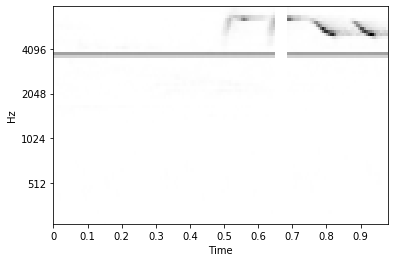

In [31]:
# Display the first example of the first batch.
# We can see the effect of data augmentation, namely:
# - the noise mixed up with the training data. The only file specified in noise/dataset.csv
#   is a pure tone at 4kHz, visible on the spectrogram.
# - both time and frequency masking (the vertical line and the horizontal line which is not the 4kHz tone)
# - time warping is hard to see, but it's there !

librosa.display.specshow(data[1][0,0].numpy(),
                         x_coords=None,
                         y_coords=None,
                         x_axis='time',
                         y_axis='mel',
                         sr=SR,
                         hop_length=HOP_LENGTH,
                         fmin=FMIN,
                         fmax=FMAX, 
                         cmap='gray_r')